# Masking HEALPix datasets

For users who do not want to simulate and fit a full sky map (e.g., to remove confusing regions) or who need patches of a HEALPix map at high resolution, IMAGINE has a Masks class derived from **ObservableDict**.  It also applies the masks correctly not only to the simulation but also the measured data sets and the corresponding observational covariances. 


In [1]:
import numpy as np
import healpy as hp
import imagine as img
import astropy.units as u
import imagine.observables as img_obs
from imagine.fields.hamx import BregLSA, TEregYMW16, CREAna

## Creating a Mask dictionary
First of all, make an example, let's mask out low latitude $|l| < 20^\circ$ pixels and those inside four local loops

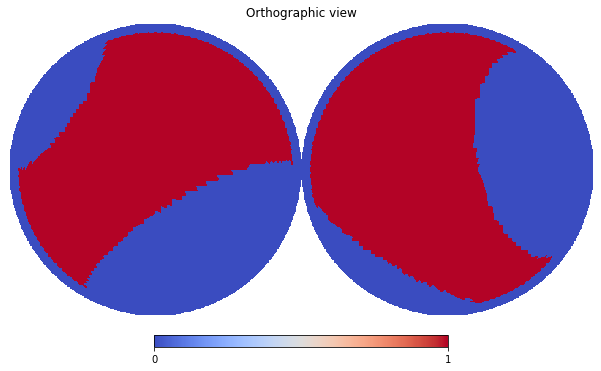

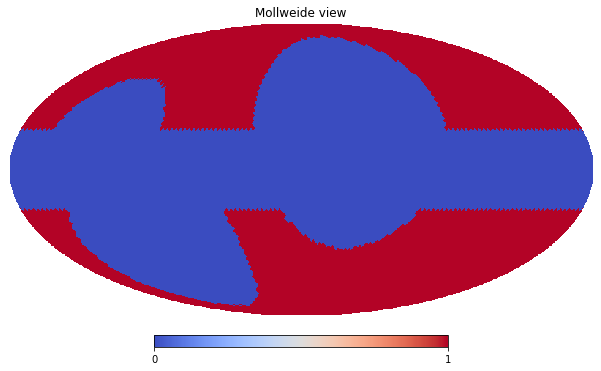

In [2]:
mask_nside = 32

def mask_map_val(_nside,_ipix):
    """Mask loops and latitude"""
    l,b = hp.pix2ang(_nside,_ipix,lonlat=True)
    R = np.pi/180.
    cue = 1
    L = [329,100,124,315]
    B = [17.5,-32.5,15.5,48.5]
    D = [116,91,65,39.5]
    #LOOP I
    if( np.arccos(np.sin(b*R)*np.sin(B[0]*R)+np.cos(b*R)*np.cos(B[0]*R)*np.cos(l*R-L[0]*R))<0.5*D[0]*R ):
        cue = 0
    #LOOP II
    if( np.arccos(np.sin(b*R)*np.sin(B[1]*R)+np.cos(b*R)*np.cos(B[1]*R)*np.cos(l*R-L[1]*R))<0.5*D[1]*R ):
        cue = 0
    #LOOP III
    if( np.arccos(np.sin(b*R)*np.sin(B[2]*R)+np.cos(b*R)*np.cos(B[2]*R)*np.cos(l*R-L[2]*R))<0.5*D[2]*R ):
        cue = 0
    #LOOP IV
    if( np.arccos(np.sin(b*R)*np.sin(B[3]*R)+np.cos(b*R)*np.cos(B[3]*R)*np.cos(l*R-L[3]*R))<0.5*D[3]*R ):
        cue = 0
    #STRIPE
    if(abs(b)<20.):
        cue = 0
    return cue

mask_map = np.zeros(hp.nside2npix(mask_nside))

for i in range(len(mask_map)):
    mask_map[i] = mask_map_val(mask_nside, i)

# Presents the generated mask map  
hp.orthview(mask_map, cmap='coolwarm', rot=(0,90))
hp.mollview(mask_map, cmap='coolwarm')

The procedure to include the above created mask in a *Masks* dictionary is the same as the *Measurements* (at the moment, the is no helper equivalent to the *Dataset*, but this should not be an issue).

In [3]:
masks = img_obs.Masks()
masks.append(('sync', '23', '32', 'I'), np.vstack([mask_map]))

## Using the Masks

The while assembling the pipeline, the masks should be supplied while initializing the *Likelihood* object, as an extra argument, for example:
```python
likelihood = img.EnsembleLikelihood(my_measurements, my_covariances, 
                                    mask_dict=masks)
```
This allows the Pipeline apply the masks, during the IMAGINE run, on both: observed and simulated data.

## Applying Masks directly

To understand or check what is going on internally when we provide a mask to a *Likelihood* object, we can apply it ourselves to a given Observable.

To illustrate this, let us first generate a mock synchrotron map using Hammurabi (using the usual trick).

In [4]:
from imagine.simulators import Hammurabi

# Creates empty datasets 
sync_dset = img_obs.SynchrotronHEALPixDataset(data=np.empty(12*32**2)*u.K, 
                                              frequency=23, type='I')
# Appends them to an Observables Dictionary
fakeMeasureDict = img_obs.Measurements()
fakeMeasureDict.append(dataset=sync_dset)
# Initializes the Simulator with the fake Measurements
simulator = Hammurabi(measurements=fakeMeasureDict)
# Initializes Fields
breg_wmap = BregLSA(parameters={'b0': 6.0, 'psi0': 27.9,
                                'psi1': 1.3, 'chi0': 24.6})
cre_ana = CREAna(parameters={'alpha': 3.0, 'beta': 0.0, 
                             'theta': 0.0,'r0': 5.6, 'z0': 1.2,
                             'E0': 20.5, 'j0': 0.03})
fereg_ymw16 = TEregYMW16(parameters={})

# Produces the mock dataset
maps = simulator([breg_wmap, cre_ana, fereg_ymw16])

observable {}
|-->  sync {'cue': '1', 'freq': '23', 'nside': '32'}


We can now inspect how this data looks before the masking takes place 

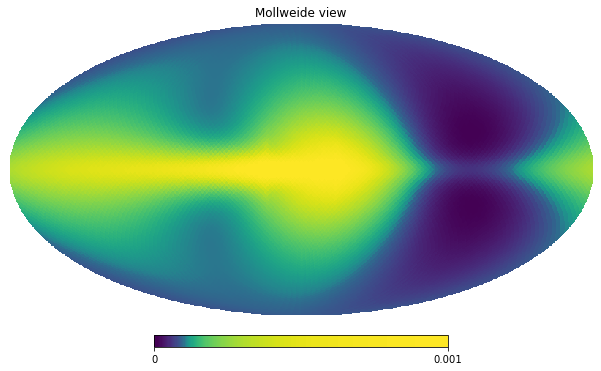

In [5]:
unmasked = maps[('sync','23','32','I')].data[0]
hp.mollview(unmasked, norm='hist', min=0, max=1.0e-3)

The mask can be applied to the `maps` observable dictionary through the method `apply_mask`

In [6]:
maps.apply_mask(masks)

raw_map = maps[('sync','23','4941','I')].data[0]

Applying a mask, however, changes the size of the data array

In [7]:
print('Masked map size:', raw_map.size)
print('Orignal map size', unmasked.size)

Masked map size: 4941
Orignal map size 12288


This is expected: the whole point of masking is not using parts of the data which are unreliable or irrelevant for a particular purpose.

However, if, to check whether things are working correctly, we wish to *look* at masked image, we need to reconstruct it. This means creating a new image including the pixels which we previously have thrown away, as exemplified below:

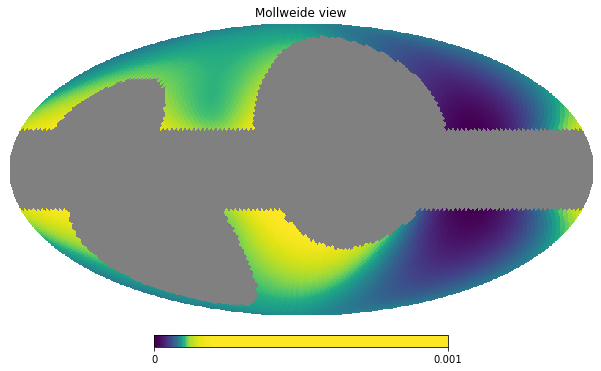

In [8]:
# Creates an empty array for the results
masked = np.empty(hp.nside2npix(mask_nside))
# Saves each pixel `raw_map` in `masked`, adding "unseen" tags for
# pixels in the mask
idx = 0
for i in range(len(mask_map)):
    if mask_map[i] == 0:
        masked[i] = hp.UNSEEN
    else:
        masked[i] = raw_map[idx]
        idx += 1
# Shows the image   
hp.mollview(masked, norm='hist', min=0, max=1.0e-3)

## Using mask in a Hammurabi X simulation

The previous procedure prevents that the masked pixels from influencing the inference, as they are not considered in the likelihood calculations. However, these pixels are still (needlessly) being computed by the Simulator.

It is possible request Hammurabi to use the prepared mask, saving thus significant computing time!

But note that there is *only a single mask input entry* for hammurabi X, which means all outputs will be masked by the same mask. And the input mask will be treated at pivot resolution, output maps may be in various resolutions by adjusting the input mask into corresponding resolution. It is not trivial in changing mask resolution, for more details please check the hammurabi X wiki.

In the following we exemplify how to instruct Hammurabi to use the mask. This involves directly manipulating hammurabiX parameters through the hampyx object (an alternative, standardized, IMAGINE interface for this is under development).

In [9]:
from os import path
# Uses IMAGINE standard temporary directory (which is erased after the end of the session)
mask_filepath = path.join(img.rc['temp_dir'], 'mask_tutorial04.bin')
# Dumps the mask to disk using hammurabi X required format: i.e. float64, binary file
mask_map.tofile(mask_filepath)
simulator._ham.mod_par(['mask'],{'cue':'1','filename': mask_filepath, 'nside':str(mask_nside)})

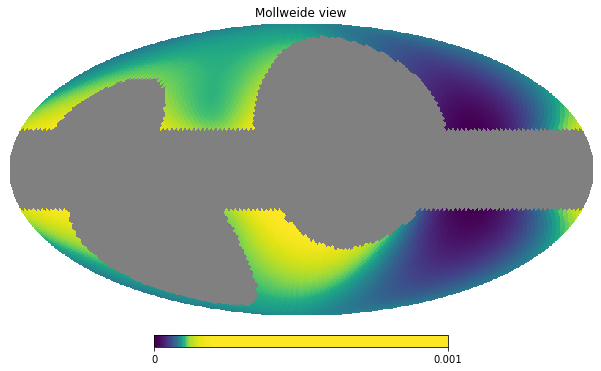

In [10]:
# Re-runs the simulator which is using the mask internally 
maps = simulator([breg_wmap, cre_ana, fereg_ymw16])
# Shows the new map
unmasked = maps[('sync','23','32','I')].data[0]
hp.mollview(masked, norm='hist', min=0, max=1.0e-3)